In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings

embedding_function = UpstageEmbeddings(model='solar-embedding-1-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [5]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [6]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [9]:
from langchain_upstage import ChatUpstage

llm = ChatUpstage(model='solar-pro2')

In [10]:
from langchain import hub

# RAG 프롬프트를 가져옵니다.
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.

    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm

    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환합니다.

In [11]:
from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옵니다.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    context = state['context']  # state에서 문맥을 추출합니다.

    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm

    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response['Score'] == 1:
        return 'generate'

    return 'rewrite'

In [12]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = ['사람과 관련된 표현 -> 거주자']

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.

    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({'query': query})

    return {'query': response}  # 변경된 질문을 포함하는 state를 반환합니다.

In [13]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [15]:
graph = graph_builder.compile()

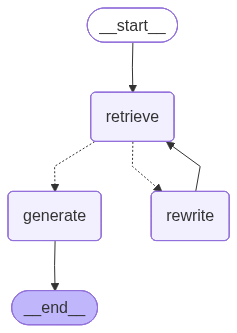

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

{'query': '연봉 5천만원 세금',
 'context': [Document(id='8ffc8a86-a526-43bf-b74b-3d14634fbcda', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우: 연 15만원